In [1]:
%load_ext autoreload
%autoreload 2a

import importlib
import io
import os
import sys
import csv
import gzip
import time
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import itertools
import collections
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

importlib.reload(lcwgsus)

/gpfs3/well/band/users/rbx225/GAMCC


<module 'lcwgsus' from '/well/band/users/rbx225/software/lcwgsus/lcwgsus/__init__.py'>

# Currently working on: HLA comparison

In [134]:
def resolve_ambiguous_hla_type(r):
    if pd.isna(r['Included Alleles']):
        r['Included Alleles'] = str(-9)
        return r
    alleles = r['Included Alleles'].split('/')
    two_fields = list(set([":".join(i.split(':', 2)[:2]) for i in alleles]))
    r['Included Alleles'] = '/'.join(two_fields)
    return r
def check_letter(s):
    for c in s:
        if c.isalpha():
            return True

def check_column(s):
    if ':' in s:
        return True

def clean_hla(r, locis = locis):
    for i in locis:
        allele = r[i]
        if check_letter(allele) or not check_column(allele):
            r[i] = '-9'
        else:
            r[i] = ":".join(allele.split(':', 2)[:2])
    return r

def reorder_alleles(r):
    a1 = r['A1']
    a2 = r['A2']
    if a1 < a2:
        r['A1'] = a1
        r['A2'] = a2
    else:
        r['A2'] = a2
        r['A1'] = a1
    return r

def clean_hla_imputed(r):
    r['sample_name'] = sample_linker[r['sample_name']]
    a1 = r['bestallele1'].split('*')[1]
    a2 = r['bestallele2'].split('*')[1]
    if a1 < a2:
        r['bestallele1'] = a1
        r['bestallele2'] = a2
    else:
        r['bestallele1'] = a2
        r['bestallele2'] = a1
    return r

def compare_hla_types(r):
    typed = set(r[['A1', 'A2']])
    imputed = set(r[['bestallele1', 'bestallele2']])
    if typed == imputed:
        r['match'] = 2
    else:
        r['match'] = len(typed.intersection(imputed))
    return r

In [23]:
loci = ['A', 'B', 'C', 'DQB1', 'DRB1']

hla = pd.read_csv('/well/band/users/rbx225/GAMCC/data/hla_direct_sequencing/HLA_direct_sequencing_all.csv')
hla = hla[['SampleID', 'Locus', 'Included Alleles']]
hla = hla[hla['Locus'].isin(loci)].reset_index(drop = True)

hla = hla.apply(resolve_ambiguous_hla_type, axis = 1)

sample_linker = pd.read_csv('data/metadata/sample_linker.csv')
sample_linker = sample_linker[~sample_linker['Sample_Name'].str.contains('mini')]
fv = list(sample_linker['Chip_Name'].values)
hla = hla[hla['SampleID'].isin(fv)]

for s in hla['SampleID'].unique():
    tmps = hla[hla['SampleID'] == s]
    for l in loci:
        tmpl = tmps[tmps['Locus'] == l]
        repeat = 2 - tmpl.shape[0]
        if repeat == 2:
            hla.loc[len(hla)] = [s, l, '-9']
            hla.loc[len(hla)] = [s, l, '-9']
        if repeat == 1:
            hla.loc[len(hla)] = [s, l, tmpl.iloc[0,2]]
hla = hla.sort_values(by = ['SampleID', 'Locus']).reset_index(drop = True)
hla

,SampleID,Locus,Included Alleles
0,GAM013489,A,02:01
1,GAM013489,B,44:03
2,GAM013489,B,82:01
3,GAM013489,C,03:02
4,GAM013489,C,03:03
...,...,...,...
1956,GAM975418,C,15:05
1957,GAM975418,DQB1,04:87/04:02
1958,GAM975418,DQB1,05:237/05:263/05:01
1959,GAM975418,DRB1,03:02


In [24]:
sample_missing = pd.DataFrame(columns = ['sample', 'missing', 'ambiguous'])
for s in hla['SampleID'].unique():
    tmps = hla[hla['SampleID'] == s]
    missing = tmps[tmps['Included Alleles'] == '-9'].shape[0]
    ambiguous = tmps[tmps['Included Alleles'].str.contains('/')].shape[0]
    sample_missing.loc[len(sample_missing)] = [s, missing, ambiguous]

In [25]:
sample_missing

,sample,missing,ambiguous
0,GAM013489,0,3
1,GAM013627,0,1
2,GAM013795,1,1
3,GAM015283,0,1
4,GAM018372,1,1
...,...,...,...
205,GAM951638,0,2
206,GAM962501,0,2
207,GAM967203,0,2
208,GAM974016,1,1


In [26]:
type_missing = pd.DataFrame(columns = ['type', 'missing', 'ambiguous'])
for l in hla['Locus'].unique():
    tmpl = hla[hla['Locus'] == l]
    missing = tmpl[tmpl['Included Alleles'] == '-9'].shape[0]
    ambiguous = tmpl[tmpl['Included Alleles'].str.contains('/')].shape[0]
    type_missing.loc[len(type_missing)] = [l, missing, ambiguous]

In [27]:
type_missing

,type,missing,ambiguous
0,A,1,0
1,B,14,0
2,C,4,0
3,DQB1,9,221
4,DRB1,73,66


In [28]:
locis = [i+'1' for i in loci] + [i+'2' for i in loci]

---

In [135]:
hla = pd.read_csv('/well/band/users/rbx225/GAMCC/data/hla_direct_sequencing/HLA_direct_sequencing.csv',
                  usecols = ['SampleID'] + locis)
hla = hla.apply(clean_hla, axis = 1)

triplet = hla[['SampleID', 'A1', 'A2']].apply(reorder_alleles, axis = 1)
triplet

,SampleID,A1,A2
0,GAM013489,02:01,02:01
1,GAM013627,01:02,01:02
2,GAM013795,29:02,34:02
3,GAM015283,66:01,74:01
4,GAM018372,02:01,68:02
...,...,...,...
245,GAM756481,30:02,68:01
246,GAM795384,33:01,33:01
247,GAM805329,30:01,68:02
248,GAM942670,23:01,68:01


In [140]:
sample_linker = pd.read_csv('data/metadata/sample_linker.csv')
idt_to_exclude = list(sample_linker[sample_linker['Sample_Name'].str.contains('mini')]['Seq_Name'].values)
sample_linker = {k:v for k, v in zip(sample_linker['Seq_Name'], sample_linker['Chip_Name'])}

imputed_A = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/genes/A/quilt.hla.output.combined.topresult.txt', sep = '\t')
imputed_A = imputed_A[['sample_name', 'bestallele1', 'bestallele2', 'post_prob']]

# imputed_A = imputed_A[~imputed_A['sample_name'].isin(idt_to_exclude)]

imputed_A = imputed_A.apply(clean_hla_imputed, axis = 1).sort_values(by = 'sample_name').reset_index(drop = True)
imputed_A

,sample_name,bestallele1,bestallele2,post_prob
0,GAM013489,02:01,02:01,0.978304
1,GAM013627,01:02,01:02,0.776611
2,GAM013795,29:02,34:02,0.999989
3,GAM015283,66:01,74:01,0.998741
4,GAM018372,02:01,68:02,0.801751
...,...,...,...,...
236,GAM962501,23:01,23:01,0.999801
237,GAM967203,03:01,26:01,0.973891
238,GAM974016,23:01,33:03,0.463453
239,GAM975418,29:02,68:02,0.398663


In [141]:
merged = pd.merge(triplet, imputed_A, left_on = 'SampleID', right_on = 'sample_name', how = 'inner').drop(columns = 'sample_name')

merged['match'] = 0
merged = merged.apply(compare_hla_types, axis = 1)
merged

,SampleID,A1,A2,bestallele1,bestallele2,post_prob,match
0,GAM013489,02:01,02:01,02:01,02:01,0.978304,2
1,GAM013627,01:02,01:02,01:02,01:02,0.776611,2
2,GAM013795,29:02,34:02,29:02,34:02,0.999989,2
3,GAM015283,66:01,74:01,66:01,74:01,0.998741,2
4,GAM018372,02:01,68:02,02:01,68:02,0.801751,2
...,...,...,...,...,...,...,...
235,GAM756481,30:02,68:01,30:10,68:01,0.794835,1
236,GAM795384,33:01,33:01,31:01,None,0.282716,0
237,GAM805329,30:01,68:02,30:01,68:02,0.902348,2
238,GAM942670,23:01,68:01,23:01,68:01,0.707046,2


In [142]:
merged['match'].sum()/(merged.shape[0]*2)

0.78125

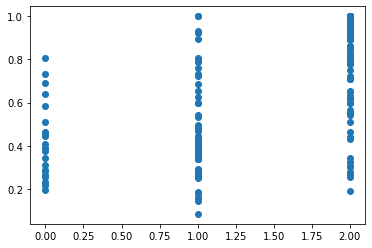

In [143]:
plt.scatter(merged['match'], merged['post_prob'])

Text(0, 0.5, 'Duplication Rate')

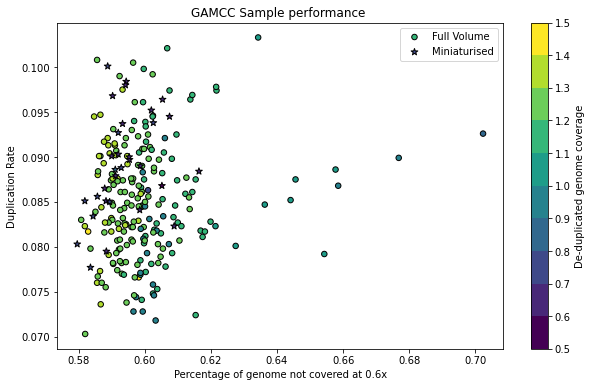

In [23]:
# util
metrics = pd.read_csv('results/metrics.csv')
fv = metrics[~metrics['Sample_Name'].str.contains('mini')]
mini = metrics[metrics['Sample_Name'].str.contains('mini')]

title = 'GAMCC Sample performance '

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)
plt.grid(False)

cmap = plt.get_cmap('viridis')
magnitude = 10
bounds = np.linspace(0.5, 1.5, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.scatter(fv['Subsample_Uncoverage_0.6x'], fv['Dup_Rate'], c = fv['Coverage'], edgecolor='black', cmap=cmap, norm=norm, s = 30, marker = 'o', label = 'Full Volume')
im = plt.scatter(mini['Subsample_Uncoverage_0.6x'], mini['Dup_Rate'], c = mini['Coverage'], edgecolor='black', cmap=cmap, norm=norm, s = 50, marker = '*', label = 'Miniaturised')
plt.colorbar(im, boundaries=bounds, ticks = bounds, label='De-duplicated genome coverage')

plt.xlabel('Percentage of genome not covered at 0.6x')
plt.title(title)
plt.legend()
plt.ylabel('Duplication Rate')
# ax = plt.gca()
# ax.grid()

In [24]:
dfs = [pd.read_csv('/well/band/users/rbx225/GAMCC/results/imputation_comparison/oneKG/lc_chip_typed/impacc/all_samples/by_sample/chr' + str(i) + ".v.impacc.tsv", sep = '\t') for i in range(1,23)]
dfs

[        AF  n_variants       NRC       NRC_BC  NRC_AC        r2        r2_BC  \
 0   0.0000        3669  0.000000     1.180556      85  0.000084  3662.694444   
 1   0.0001        1787  0.004444     1.256983     225  0.001865  1782.832402   
 2   0.0002         739  0.000000     1.194805      92  0.000008   737.051948   
 3   0.0005        1254  0.084746     1.053571      59  0.091030  1250.357143   
 4   0.0010        1039  0.486486     1.057143      37  0.482246  1037.257143   
 5   0.0020        1292  0.305085     1.638889     295  0.089450  1288.688889   
 6   0.0050        3297  0.872187     6.038043    1111  0.787288  3290.195652   
 7   0.0100        3248  0.954545    26.731183    4972  0.925033  3239.774194   
 8   0.0200        5550  0.972722   145.456989   27055  0.958819  5536.263441   
 9   0.0500        9226  0.981256   582.564516  108357  0.974149  9199.489247   
 10  0.1000        6213  0.982374   851.016129  158289  0.975608  6192.172043   
 11  0.2000        6147  0.9

In [25]:
s1 = 0
s5 = 0
for df in dfs:
    s1 += df[df['AF'] > 0.01]['n_variants'].sum()
    s5 += df[df['AF'] > 0.05]['n_variants'].sum()

In [3]:
hla = pd.read_csv('/well/band/users/rbx225/GAMCC/data/hla_direct_sequencing/HLA_direct_sequencing.csv',
                  usecols = ['SampleID'] + locis)
hla = hla.apply(clean_hla, axis = 1)

triplet = hla[['SampleID', 'A1', 'A2']].apply(reorder_alleles, axis = 1)
triplet

chip = lcwgsus.read_vcf('/well/band/users/rbx225/GAMCC/results/hla/server/chr6.dose.vcf.gz')
chip

,chr,pos,ID,ref,alt,QUAL,FILTER,INFO,FORMAT,GAM013489,...,GAM897412,GAM905721,GAM907384,GAM916387,GAM918732,GAM942670,GAM946580,GAM951206,GAM967203,GAM975418
0,6,27970031,rs149946,G,T,.,PASS,AF=0.43817;MAF=0.43817;R2=0.99996;ER2=0.99816;...,GT:DS:HDS:GP,"1|0:1.000:1.000,0.000:0.000,1.000,0.000",...,"0|1:1.000:0.000,1.000:0.000,1.000,0.000","0|1:1.000:0.000,1.000:0.000,1.000,0.000","0|0:0:0,0:1,0,0","0|1:1.000:0.000,1.000:0.000,1.000,0.000","0|0:0:0,0:1,0,0","0|1:1.000:0.000,1.000:0.000,1.000,0.000","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","1|0:1.000:1.000,0.000:0.000,1.000,0.000"
1,6,27976200,rs9380032,G,T,.,PASS,AF=0.01884;MAF=0.01884;R2=0.99851;ER2=0.97732;...,GT:DS:HDS:GP,"0|0:0:0,0:1,0,0",...,"0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0"
2,6,27979188,rs4141691,A,G,.,PASS,AF=0.25551;MAF=0.25551;R2=0.99905;ER2=0.96712;...,GT:DS:HDS:GP,"0|0:0:0,0:1,0,0",...,"0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","1|0:1.000:1.000,0.000:0.000,1.000,0.000","1|0:1.000:1.000,0.000:0.000,1.000,0.000","0|1:1.000:0.000,1.000:0.000,1.000,0.000","1|0:1.000:1.000,0.000:0.000,1.000,0.000","0|1:1.000:0.000,1.000:0.000,1.000,0.000"
3,6,27979625,rs10484402,A,G,.,PASS,AF=0.06978;MAF=0.06978;R2=0.99817;ER2=0.89370;...,GT:DS:HDS:GP,"0|0:0:0,0:1,0,0",...,"0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|1:1.000:0.000,1.000:0.000,1.000,0.000","0|0:0:0,0:1,0,0","0|1:0.999:0.000,0.999:0.001,0.999,0.000","1|0:1.000:1.000,0.000:0.000,1.000,0.000","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0"
4,6,27981673,rs9368540,G,A,.,PASS,AF=0.00003;MAF=0.00003;R2=0.00304;IMPUTED,GT:DS:HDS:GP,"0|0:0:0,0:1,0,0",...,"0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22728,6,33963501,rs2451370,A,G,.,PASS,AF=0.98307;MAF=0.01693;R2=0.94885;ER2=0.33079;...,GT:DS:HDS:GP,"1|1:2.000:1.000,1.000:0.000,0.000,1.000",...,"1|1:1.998:1.000,0.998:0.000,0.002,0.998","0|1:1.001:0.001,1.000:0.000,0.999,0.001","1|1:1.999:0.999,1.000:0.000,0.001,0.999","1|1:2.000:1.000,1.000:0.000,0.000,1.000","1|1:2.000:1.000,1.000:0.000,0.000,1.000","1|1:1.994:0.994,1.000:0.000,0.006,0.994","1|1:1.999:1.000,0.999:0.000,0.001,0.999","1|1:1.997:0.999,0.998:0.000,0.003,0.997","1|1:2.000:1.000,1.000:0.000,0.000,1.000","1|1:1.998:0.998,1.000:0.000,0.002,0.998"
22729,6,33963845,rs55929002,G,C,.,PASS,AF=0.00714;MAF=0.00714;R2=0.15576;IMPUTED,GT:DS:HDS:GP,"0|0:0:0,0:1,0,0",...,"0|0:0.071:0.000,0.071:0.929,0.071,0.000","0|0:0:0,0:1,0,0","0|0:0.002:0.000,0.002:0.998,0.002,0.000","0|0:0:0,0:1,0,0","0|0:0.001:0.000,0.001:0.999,0.001,0.000","0|0:0.013:0.001,0.012:0.987,0.013,0.000","0|0:0.003:0.000,0.003:0.997,0.003,0.000","0|0:0.258:0.000,0.258:0.742,0.258,0.000","0|0:0.020:0.000,0.020:0.980,0.020,0.000","0|0:0.013:0.013,0.000:0.987,0.013,0.000"
22730,6,33965321,rs73406709,G,A,.,PASS,AF=0.29371;MAF=0.29371;R2=0.60785;IMPUTED,GT:DS:HDS:GP,"0|0:0.009:0.004,0.004:0.991,0.009,0.000",...,"0|0:0.440:0.001,0.439:0.560,0.439,0.000","0|0:0:0,0:1,0,0","1|0:0.631:0.628,0.003:0.370,0.628,0.002","0|0:0.039:0.037,0.002:0.961,0.039,0.000","0|0:0.404:0.005,0.399:0.598,0.400,0.002","1|0:0.654:0.539,0.115:0.408,0.530,0.062","0|1:0.790:0.001,0.789:0.211,0.788,0.001","0|0:0.192:0.089,0.103:0.817,0.174,0.009","0|1:0.795:0.001,0.795:0.205,0.794,0.001","0|0:0.098:0.098,0.000:0.902,0.098,0.000"
22731,6,33965434,rs7745522,C,T,.,PASS,AF=0.09285;MAF=0.09285;R2=0.52669;IMPUTED,GT:DS:HDS:GP,"0|0:0.006:0.003,0.003:0.994,0.006,0.000",...,"1|0:1.199:0.896,0.303:0.072,0.656,0.271","0|0:0:0,0:1,0,0","0|0:0.105:0.099,0.005:0.896,0.104,0.001","0|0:0.147:0.146,0.001:0.853,0.147,0.000","0|0:0.007:0.004,0.003:0.994,0.006,0.000","0|0:0.078:0.07

In [5]:
chip = chip[(chip['ID'].str.contains('HLA_A')) & (chip['ID'].str.contains(':'))]
chip

,chr,pos,ID,ref,alt,QUAL,FILTER,INFO,FORMAT,GAM013489,...,GAM897412,GAM905721,GAM907384,GAM916387,GAM918732,GAM942670,GAM946580,GAM951206,GAM967203,GAM975418
2960,6,29910248,HLA_A*01:01,A,T,.,PASS,AF=0.04299;MAF=0.04299;R2=0.99739;IMPUTED,GT:DS:HDS:GP,"0|0:0:0,0:1,0,0",...,"1|1:2.000:1.000,1.000:0.000,0.000,1.000","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","1|0:1.000:1.000,0.000:0.000,1.000,0.000","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0"
2961,6,29910249,HLA_A*01:02,A,T,.,PASS,AF=0.03497;MAF=0.03497;R2=0.99779;IMPUTED,GT:DS:HDS:GP,"0|0:0:0,0:1,0,0",...,"0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0"
2962,6,29910250,HLA_A*01:136,A,T,.,PASS,AF=0.00000;MAF=0.00000;R2=0.00008;IMPUTED,GT:DS:HDS:GP,"0|0:0:0,0:1,0,0",...,"0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0"
2964,6,29910252,HLA_A*02:01,A,T,.,PASS,AF=0.06371;MAF=0.06371;R2=0.98309;IMPUTED,GT:DS:HDS:GP,"1|1:2.000:1.000,1.000:0.000,0.000,1.000",...,"0|0:0:0,0:1,0,0","0|0:0.001:0.001,0.000:0.999,0.001,0.000","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|1:1.000:0.000,1.000:0.000,1.000,0.000","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0"
2965,6,29910253,HLA_A*02:02,A,T,.,PASS,AF=0.03763;MAF=0.03763;R2=0.99925;IMPUTED,GT:DS:HDS:GP,"0|0:0:0,0:1,0,0",...,"0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","1|0:1.000:1.000,0.000:0.000,1.000,0.000","0|0:0:0,0:1,0,0","0|1:0.999:0.000,0.999:0.001,0.999,0.000","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061,6,29910349,HLA_A*74:01,A,T,.,PASS,AF=0.02693;MAF=0.02693;R2=0.99405;IMPUTED,GT:DS:HDS:GP,"0|0:0:0,0:1,0,0",...,"0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","1|0:1.000:1.000,0.000:0.000,1.000,0.000","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0"
3062,6,29910350,HLA_A*74:03,A,T,.,PASS,AF=0.00000;MAF=0.00000;R2=0.00010;IMPUTED,GT:DS:HDS:GP,"0|0:0:0,0:1,0,0",...,"0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0"
3063,6,29910351,HLA_A*74:09,A,T,.,PASS,AF=0.00000;MAF=0.00000;R2=0.00034;IMPUTED,GT:DS:HDS:GP,"0|0:0:0,0:1,0,0",...,"0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0"
3064,6,29910352,HLA_A*74:11,A,T,.,PASS,AF=0.00006;MAF=0.00006;R2=0.01996;IMPUTED,GT:DS:HDS:GP,"0|0:0:0,0:1,0,0",...,"0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0","0|0:0:0,0:1,0,0"


---

In [15]:
sample_linker='data/metadata/sample_linker.csv'
sample_linker = pd.read_csv(sample_linker)
sample_linker = sample_linker[(sample_linker['Sample_Name'].str.contains('mini')) & (sample_linker['Sample_Name'].str.contains('GM'))]
sample_linker = sample_linker[sample_linker['Chip_Name'].isin(chip)]
sample_linker

,Sample_Name,Seq_Name,Chip_Name
210,GM101_mini,IDT0607,GAM314862
211,GM1114_mini,IDT0634,GAM916387
212,GM1126_mini,IDT0597,GAM684932
213,GM1135_mini,IDT0596,GAM519367
214,GM1151_mini,IDT0609,GAM870643
215,GM1211_mini,IDT0669,GAM865304
216,GM1232_mini,IDT0646,GAM806425
217,GM1293_mini,IDT0619,GAM752031
218,GM1555_mini,IDT0621,GAM892761
219,GM197_mini,IDT0631,GAM503647


In [5]:
chip = 'data/sample_tsvs/chip_gam_names.tsv'
chip = pd.read_csv(chip, header = None, names = ['Code'])['Code'].values
sl = {k:v for k, v in zip(sample_linker['Chip_Name'], sample_linker['Seq_Name'])}

idts = []

for i in chip:
    idts.append(sl[i])

res = pd.DataFrame({'seq': idts, 'chip': chip})
res.to_csv('/well/band/users/rbx225/GAMCC/data/rename_tsvs/idt_to_gam_chip.tsv', sep = ' ', index = False, header = False)

In [28]:
quilt1_vcf = '/well/band/users/rbx225/GAMCC/results/imputation/vcfs/oneKG/quilt.chr11.vcf.gz'
quilt2_vcf = '/well/band/users/rbx225/GAMCC/results/two-stage-imputation/oneKG_oneKG/vcf/chr11.dose.vcf.gz'
chip_vcf = '/well/band/users/rbx225/GAMCC/results/chip/vcf/chip_by_chr/chip.chr11.vcf.gz'
hc_vcf = '/well/band/users/rbx225/GAMCC/results/call/recal_vcf/oneKG/snps/oneKG.snps.chr11.vcf.gz'
af_txt = "data/gnomAD_MAFs/afr/gnomAD_MAF_afr_chr11.txt"

vcf_cols = [
    'chr', 'pos', 'ID', 'ref', 'alt', 'QUAL', 'FILTER', 'INFO', 'FORMAT'
]

c = 11
pos = 5227002
vcf_lst = [chip_vcf, quilt1_vcf, quilt2_vcf]
source_lst = ['chip', 'lc', 'lc']
labels_lst = ['chip', 'lc', 'two-stage']

In [ ]:
chromosomes = [str(i) for i in range(1,23)]
h_lst = ["results/imputation_metrics/lc_chip/by_variant/lc.chip.typed.chr" + i + ".h.impacc.tsv" for i in chromosomes]
v_lst = ["results/imputation_metrics/lc_chip/by_sample/lc.chip.typed.chr" + i + ".v.impacc.tsv" for i in chromosomes]

h_dfs = [pd.read_csv(i, sep = '\t') for i in h_lst]
v_dfs = [pd.read_csv(i, sep = '\t') for i in v_lst]

h = lcwgsus.average_impacc_by_chr(h_dfs)
v = lcwgsus.average_impacc_by_chr(v_dfs)

In [ ]:
dfs = [h[['AF', 'r2', 'r2_AC']], h[['AF', 'NRC', 'NRC_AC']]]
lcwgsus.plot_imputation_accuracy(dfs, title = 'r2 and NRC by variant')

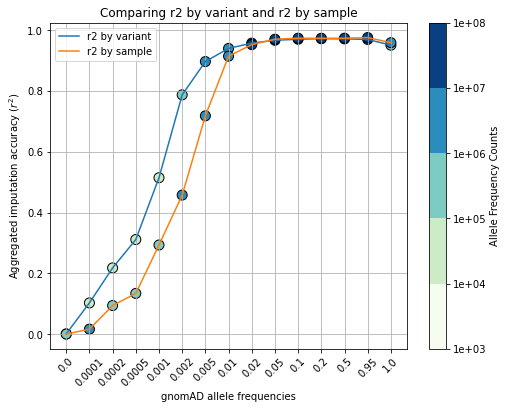

In [194]:
dfs = [h[['AF', 'r2', 'r2_AC']], v[['AF', 'r2', 'r2_AC']]]
plot_imputation_accuracy(dfs, labels = ['r2 by variant', 'r2 by sample'], title = 'Comparing r2 by variant and r2 by sample')

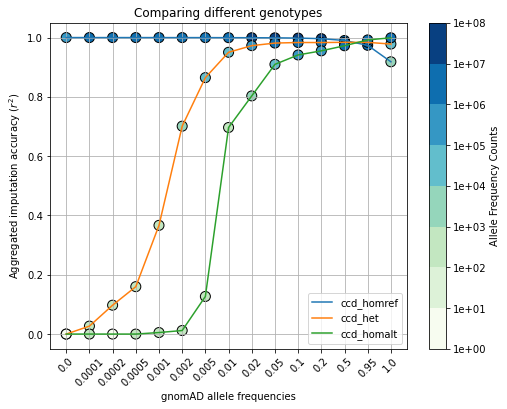

In [196]:
dfs = [h[['AF', 'ccd_homref', 'ccd_homref_AC']], h[['AF', 'ccd_het', 'ccd_het_AC']], h[['AF', 'ccd_homalt', 'ccd_homalt_AC']]]
plot_imputation_accuracy(dfs, title = 'Comparing different genotypes')

# Current working on exploring questions
---

In [2]:
metrics = pd.read_csv('results/metrics.csv')
metrics = metrics[~metrics['Sample_Name'].str.contains('mini')]
sl = pd.read_csv('data/metadata/sample_linker.csv')
ethnics = pd.read_csv('data/metadata/ethnic_group.csv')

merged = pd.merge(sl, ethnics, on = 'Chip_Name', how = 'inner')
merged = pd.merge(metrics, merged, on = 'Sample_Name', how = 'inner')
merged

,Code,Sample_Name,Dup_Rate,Coverage,Fragment_Size,% > 500,Overlap,Uncoverage,Subsample_Uncoverage_0.6x,Sequencing_Skew_0.6x,Seq_Name,Chip_Name,ethnic
0,IDT0481,GM8,0.0781,1.1840,327.4035,0.049686,313440329,0.3936,0.6020,0.882254,IDT0481,GAM057236,Mandinka
1,IDT0482,GM42,0.0753,1.1506,306.6867,0.029178,382515893,0.4103,0.6038,0.878273,IDT0482,GAM164079,Wollof
2,IDT0483,GM50,0.0874,1.1348,320.6687,0.041466,329639861,0.4140,0.6098,0.864823,IDT0483,GAM348792,Mandinka
3,IDT0484,GM67,0.0808,1.2140,324.0475,0.051454,339760254,0.3995,0.5960,0.895295,IDT0484,GAM086135,Fula
4,IDT0485,GM101,0.0817,1.3625,332.2264,0.059887,342067708,0.3437,0.5899,0.909137,IDT0485,GAM314862,Fula
...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,IDT0764,GM872,0.0703,1.2995,346.9935,0.074832,249191840,0.3515,0.5820,0.926500,IDT0764,GAM975418,Jola
206,IDT0765,GM1110,0.1008,1.2978,360.4852,0.094996,210953270,0.3609,0.5856,0.918462,IDT0765,GAM514987,Jola
207,IDT0766,GM1114,0.0808,1.2340,334.6547,0.056636,280966337,0.3762,0.5925,0.903149,IDT0766,GAM916387,Fula
208,IDT0767,GM1117,0.0755,1.2713,331.0397,0.051057,294630942,0.3666,0.5882,0.912824,IDT0767,GAM612549,Mandinka


Mandinka 1.1812941176470588
Wollof 1.215869230769231
Fula 1.2250283018867922
Jola 1.2036185185185189


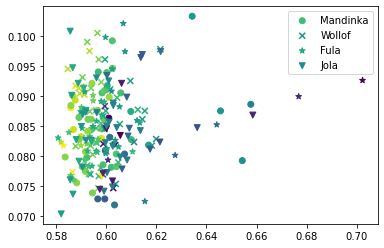

In [18]:
shape = ['o', 'x', '*', 'v']
for i,s in zip(merged['ethnic'].unique(), shape):
    t = merged[merged['ethnic'] == i]
    plt.scatter(t['Subsample_Uncoverage_0.6x'], t['Dup_Rate'], c = t['Coverage'], marker = s, label = i)
    print(i, t['Coverage'].mean())
plt.legend()
plt.show()

<AxesSubplot:xlabel='ethnic', ylabel='Coverage'>

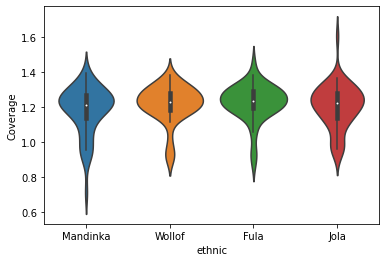

In [17]:
sns.violinplot(data = merged, x = 'ethnic', y = 'Coverage')

In [16]:
metrics = pd.read_csv('results/metrics.csv')
# metrics = metrics[~metrics['Sample_Name'].str.contains('mini')]
# sl = pd.read_csv('data/metadata/sample_linker.csv')
# ethnics = pd.read_csv('data/metadata/ethnic_group.csv')

# merged = pd.merge(sl, ethnics, on = 'Chip_Name', how = 'inner')
# merged = pd.merge(metrics, merged, on = 'Sample_Name', how = 'inner')
merged = metrics

In [17]:
mini = merged[merged['Sample_Name'].str.contains('mini')]
fv = merged[~merged['Sample_Name'].str.contains('mini')]

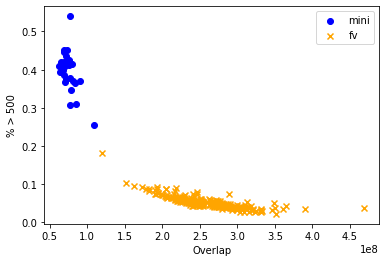

In [28]:
plt.scatter(mini['Overlap']/mini['Coverage'], mini['% > 500'], marker = 'o', c = 'blue', label = 'mini')
plt.scatter(fv['Overlap']/fv['Coverage'], fv['% > 500'], marker = 'x', c = 'orange', label = 'fv')
plt.xlabel('Overlap')
plt.ylabel('% > 500')
plt.legend()
plt.show()

<AxesSubplot:xlabel='label', ylabel='% > 500'>

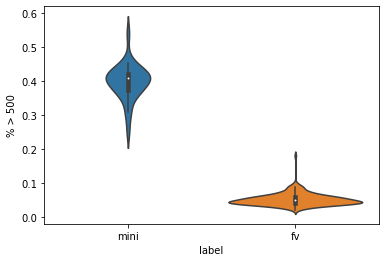

In [25]:
sns.violinplot(data = a, x = 'label', y = '% > 500')